In [2]:
import numpy as np
import qutip as qt

In [3]:
ket_0 = qt.basis(2, 0)
ket_1 = qt.basis(2, 1)

ket_00 = qt.tensor(ket_0, ket_0)
ket_11 = qt.tensor(ket_1, ket_1)
ket_01 = qt.tensor(ket_0, ket_1)
ket_10 = qt.tensor(ket_1, ket_0)

a = (np.sqrt(5) - 1) / 2

ket_phi = a * (ket_01 + ket_10) + np.sqrt(1-2*a**2) * ket_11
ket_phi

Quantum object: dims=[[2, 2], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.        ]
 [0.61803399]
 [0.61803399]
 [0.48586827]]

In [4]:
rho_phi = ket_phi * ket_phi.dag()
rho_phi

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.         0.         0.        ]
 [0.         0.38196601 0.38196601 0.30028311]
 [0.         0.38196601 0.38196601 0.30028311]
 [0.         0.30028311 0.30028311 0.23606798]]

In [5]:
proj_0 = ket_0 * ket_0.dag()
proj_1 = ket_1 * ket_1.dag()

psi = 1 / np.sqrt(1-a**2) * (np.sqrt(1-2*a**2) * ket_0 - a * ket_1)
proj_psi = psi * psi.dag()

proj_0, proj_1, proj_psi, 1 - proj_psi

(Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
 Qobj data =
 [[1. 0.]
  [0. 0.]],
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
 Qobj data =
 [[0. 0.]
  [0. 1.]],
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[ 0.38196601 -0.48586827]
  [-0.48586827  0.61803399]],
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[0.61803399 0.48586827]
  [0.48586827 0.38196601]])

# 1 Copy

In [6]:
def p(a, b, x, y):
    if x == 1:
        proj_a = proj_0 if a == 0 else proj_1
    else:
        proj_a = proj_psi if a == 0 else (1 - proj_psi)

    if y == 1:
        proj_b = proj_0 if b == 0 else proj_1
    else:
        proj_b = proj_psi if b == 0 else (1 - proj_psi)

    proj_ab = qt.tensor(proj_a, proj_b)
    return (proj_ab * rho_phi).tr()

p(0, 1, 0, 1), p(1,0,1,0), p(0,0,1,1), p(0,0,0,0)

(0.0, 0.0, 0.0, (0.09016994374947418+0j))

Note - the above has the definition of x swapped, so that when x=0, we project in the psi basis, and when x=1, we project in the logical basis

# 2 Copies

In [7]:
def phi_n(n):
    return qt.tensor([ket_phi] * n)

phi_2 = phi_n(2)
phi_2

Quantum object: dims=[[2, 2, 2, 2], [1]], shape=(16, 1), type='ket', dtype=Dense
Qobj data =
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.38196601]
 [0.38196601]
 [0.30028311]
 [0.        ]
 [0.38196601]
 [0.38196601]
 [0.30028311]
 [0.        ]
 [0.30028311]
 [0.30028311]
 [0.23606798]]

In [8]:
def proj_ab_n(a_vals, b_vals, x, y):
    n = len(a_vals)
    # Precompute projectors for efficiency
    proj_a_basis = [proj_0, proj_1] if x == 1 else [proj_psi, 1 - proj_psi]
    proj_b_basis = [proj_0, proj_1] if y == 1 else [proj_psi, 1 - proj_psi]

    projs = [
        qt.tensor(proj_a_basis[a], proj_b_basis[b])
        for a, b in zip(a_vals, b_vals)
    ]
    return qt.tensor(projs)


def p_n(a_vals, b_vals, x, y):
    n = len(a_vals)
    assert len(b_vals) == n

    proj_ab = proj_ab_n(a_vals, b_vals, x, y)
    rho = phi_n(n) * phi_n(n).dag()
    return (proj_ab * rho).tr()


In [9]:
# (a1 b1)(a2 b2) ... (an bn)
# (00)(00) + (00)(01) + (00)(10) + (00)(11) + (01)(00) + (10)(00) + (11)(00)

# (a1 a2) (b1 b2)
# (00)(00) + (00)(01) + (01)(00) + (01)(01) + (00)(10) + (10)(00) + (10)(10)

np.sum([p_n([0,0], [0,0], 0, 0),
        p_n([0,0], [0,1], 0, 0),
        p_n([0,1], [0,0], 0, 0),
        p_n([0,1], [0,1], 0, 0),
        p_n([0,0], [1,0], 0, 0),
        p_n([1,0], [0,0], 0, 0),
        p_n([1,0], [1,0], 0, 0)])

np.complex128(0.1722092687431651+0j)

# N Copies

In [10]:
# Pairs of bits, times n, iff at least one pair of bits is (0,0)
from itertools import product

def get_sum_terms(n: int):
    pairs = [(0,0), (0,1), (1,0), (1,1)]
    all_terms = []
    for seq in product(pairs, repeat=n):
        if (0,0) in seq:
            all_terms.append(list(seq))  # convert tuple to list
    return np.array([list(list(t) for t in term) for term in all_terms])

get_sum_terms(3)

array([[[0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 1]],

       [[0, 0],
        [0, 0],
        [1, 0]],

       [[0, 0],
        [0, 0],
        [1, 1]],

       [[0, 0],
        [0, 1],
        [0, 0]],

       [[0, 0],
        [0, 1],
        [0, 1]],

       [[0, 0],
        [0, 1],
        [1, 0]],

       [[0, 0],
        [0, 1],
        [1, 1]],

       [[0, 0],
        [1, 0],
        [0, 0]],

       [[0, 0],
        [1, 0],
        [0, 1]],

       [[0, 0],
        [1, 0],
        [1, 0]],

       [[0, 0],
        [1, 0],
        [1, 1]],

       [[0, 0],
        [1, 1],
        [0, 0]],

       [[0, 0],
        [1, 1],
        [0, 1]],

       [[0, 0],
        [1, 1],
        [1, 0]],

       [[0, 0],
        [1, 1],
        [1, 1]],

       [[0, 1],
        [0, 0],
        [0, 0]],

       [[0, 1],
        [0, 0],
        [0, 1]],

       [[0, 1],
        [0, 0],
        [1, 0]],

       [[0, 1],
        [0, 0],
        [1, 1]],



In [11]:
np.sum([p_n(term.transpose()[0], term.transpose()[1], 0, 0) for term in get_sum_terms(1)])

np.complex128(0.09016994374947418+0j)

# k Outcomes

In [12]:
def p_n_k(n):
    if n == 1: 
        return # Not supported
    terms = get_sum_terms(n)
    k = len(terms)

    a_vals_k = terms.transpose()[0].transpose()
    b_vals_k = terms.transpose()[1].transpose()

    proj_ab_n_sum = 0

    for i in range(k):
        a_vals = a_vals_k[i]
        b_vals = b_vals_k[i]
        proj_ab_n_i = proj_ab_n(a_vals, b_vals, 0, 0)

        proj_ab_n_sum += proj_ab_n_i

    rho_n = phi_n(n) * phi_n(n).dag()
    p = (proj_ab_n_sum * rho_n).tr()
    return p


In [13]:
for i in range(3,6):
    print(i, p_n_k(i))

3 (0.2468511124169302+0j)
4 (0.31476250524527366+0j)
5 (0.3765503316023426+0j)


# Invert Projector Calc

Once $N > 2$, $(3/4) ^ N < 1/2$, which means more of the outcome patterns are included in the sum than excluded. So for efficiency, we will calculate the ones not included, and then subtract from 1.

In [14]:
proj_psi_psi = qt.tensor(proj_psi, proj_psi)
proj_psi_apsi = qt.tensor(proj_psi, 1-proj_psi)
proj_apsi_psi = qt.tensor(1-proj_psi, proj_psi)
proj_apsi_apsi = qt.tensor(1-proj_psi, 1-proj_psi)

# tensor power of the sum
excluded_proj = 1 - proj_psi_psi
excluded_proj

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.85410197  0.18558517  0.18558517 -0.23606798]
 [ 0.18558517  0.76393202 -0.23606798  0.30028311]
 [ 0.18558517 -0.23606798  0.76393202  0.30028311]
 [-0.23606798  0.30028311  0.30028311  0.61803399]]

In [15]:
def p_n_k_from_inverted(n):
    proj_excluded = 1-proj_psi_psi

    rho_n = ket_phi * ket_phi.dag()

    return 1 - (proj_excluded * rho_n).tr() ** n

In [16]:
p_n_k_from_inverted(10)

(0.6113105109748465+0j)

In [17]:
for i in range(1,20):
    print(i, p_n_k_from_inverted(i))

1 (0.09016994374947429+0j)
2 (0.17220926874316522+0j)
3 (0.24685111241693025+0j)
4 (0.3147625052452747+0j)
5 (0.376550331602339+0j)
6 (0.43276675313238444+0j)
7 (0.48391414309526903+0j)
8 (0.5304495757822678+0j)
9 (0.5727889111215225+0j)
10 (0.6113105109748465+0j)
11 (0.6463586203362566+0j)
12 (0.6782464436480227+0j)
13 (0.7072589437254738+0j)
14 (0.7336553883029096+0j)
15 (0.7576716669576118+0j)
16 (0.7795223991169478+0j)
17 (0.7994028519865917+0j)
18 (0.8174906855392656+0j)
19 (0.8339475401579451+0j)


/Users/Joseph/Documents/PhD/projects/bell-non-locality/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/Joseph/Documents/PhD/projects/bell-non-locality/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


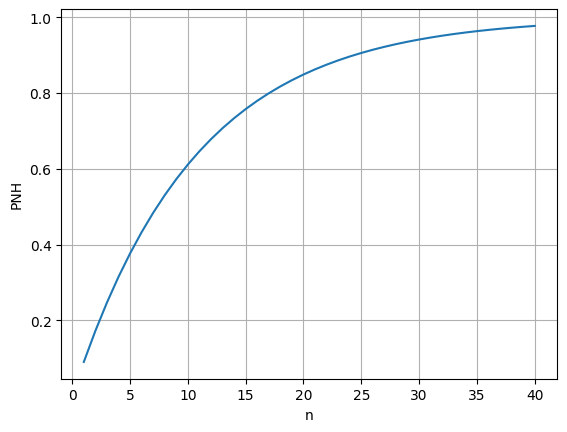

In [18]:
# plot the P(n, k) values for n in [1, 20]
import matplotlib.pyplot as plt

x = list(range(1, 41))
y = [p_n_k_from_inverted(i) for i in x]

plt.plot(x, y)
plt.xlabel('n')
plt.ylabel('PNH')

plt.grid()

plt.savefig('P_N_H.png')
plt.show()

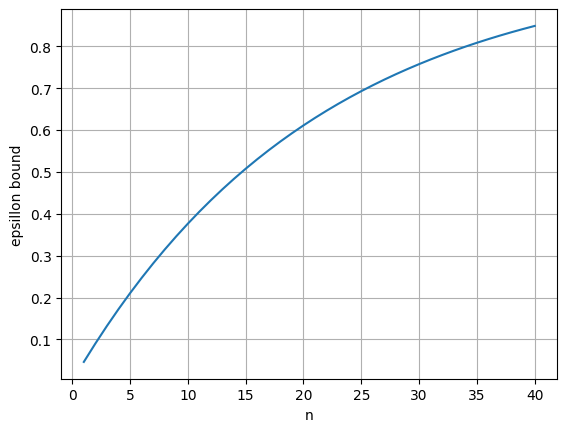

In [19]:
# plot epsillon = 1 - root(1 - P(n, k))
import matplotlib.pyplot as plt
x = list(range(1, 41))
y = [1 - np.sqrt(1 - p_n_k_from_inverted(i)) for i in x]
plt.plot(x, y)
plt.xlabel('n')
plt.ylabel('epsillon bound')
plt.grid()

plt.savefig('epsillon_bound.png')
plt.show()

# Checking eq. 14

## 14a

In [21]:
proj_psi_1 = qt.tensor(proj_psi, proj_1)
proj_psi_1

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.          0.          0.          0.        ]
 [ 0.          0.38196601  0.         -0.48586827]
 [ 0.          0.          0.          0.        ]
 [ 0.         -0.48586827  0.          0.61803399]]

In [28]:
s_01 = 1 - ((1-proj_psi_1) * rho_phi).tr()
s_01

0.0

## 14b

In [29]:
proj_1_psi = qt.tensor(proj_1, proj_psi)
proj_1_psi

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.38196601 -0.48586827]
 [ 0.          0.         -0.48586827  0.61803399]]

In [30]:
s_10 = 1 - ((1-proj_1_psi) * rho_phi).tr()
s_10

0.0

## 14c

In [31]:
proj_0_0 = qt.tensor(proj_0, proj_0)
proj_0_0

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [32]:
# GIVEN 1, 1 !
s_00 = 1 - ((1-proj_0_0) * rho_phi).tr()
s_00

0.0